## Introduction

In this assignment, we are going to implement a Variational Auto-Encoder (VAE). A VAE is a likelihood-based deep generative model that consists of a stochastic encoder (a variational posterior over latent variables), a stochastic decoder, and a marginal distribution over latent variables (a.k.a. a prior). The model was originally proposed in two concurrent papers:
- [Kingma, D. P., & Welling, M. (2013). Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.](https://arxiv.org/abs/1312.6114)
- [Rezende, Danilo Jimenez, Shakir Mohamed, and Daan Wierstra. "Stochastic backpropagation and approximate inference in deep generative models." International conference on machine learning. PMLR, 2014.](https://proceedings.mlr.press/v32/rezende14.html)

You can read more about VAEs in Chapter 4 of the following book:
- [Tomczak, J.M., "Deep Generative Modeling", Springer, 2022](https://link.springer.com/book/10.1007/978-3-030-93158-2)

In particular, the goals of this assignment are the following:

- Understand how VAEs are formulated
- Implement components of VAEs using PyTorch
- Train and evaluate a model for image data

### Theory behind VAEs

VAEs are latent variable models trained with variational inference. In general, the latent variable models define the following generative process:
\begin{align}
1.\ & \mathbf{z} \sim p_{\lambda}(\mathbf{z}) \\
2.\ & \mathbf{x} \sim p_{\theta}(\mathbf{x}|\mathbf{z})
\end{align}

In plain words, we assume that for observable data $\mathbf{x}$, there are some latent (hidden) factors $\mathbf{z}$. Then, the training objective is log-likelihood function of the following form:
$$
\log p_{\vartheta}(\mathbf{x})=\log \int p_\theta(\mathbf{x} \mid \mathbf{z}) p_\lambda(\mathbf{z}) \mathrm{d} \mathbf{z} .
$$

The problem here is the intractability of the integral if the dependencies between random variables $\mathbf{x}$ and $\mathbf{z}$ are non-linear and/or the distributions are non-Gaussian.

By introducing variational posteriors $q_{\phi}(\mathbf{z}|\mathbf{x})$, we get the following lower bound (the Evidence Lower Bound, ELBO):
$$
\log p_{\vartheta}(\mathbf{x}) \geq \mathbb{E}_{\mathbf{z} \sim q_\phi(\mathbf{z} \mid \mathbf{x})}\left[\log p_\theta(\mathbf{x} \mid \mathbf{z})\right]-\mathrm{KL}\left(q_\phi(\mathbf{z} \mid \mathbf{x}) \| p_\lambda(\mathbf{z})\right) .
$$

Note that we want to *maximize* this objective, therefore, in the code you are going to have to implement NELBO (negative ELBO) as a loss function (i.e., a minimization task). 

## IMPORTS

In [ ]:
# DO NOT REMOVE!
import os

import numpy as np
import matplotlib.pyplot as plt

import torch

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.datasets import MNIST

In [ ]:
# Check if GPU is available and determine the device
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

print(f'The available device is {device}')

The available device is cuda


In [ ]:
# mount drive: WE NEED IT FOR SAVING IMAGES!
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# PLEASE CHANGE IT TO YOUR OWN GOOGLE DRIVE!
images_dir = '/content/drive/MyDrive/Colab Notebooks/Results'

## Auxiliary functions

Let us define some useful log-distributions:

In [ ]:
# DO NOT REMOVE
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-5


def log_categorical(x, p, num_classes=256, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(p, EPS, 1. - EPS))

    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_bernoulli(x, p, reduction=None, dim=None):
    pp = torch.clamp(p, EPS, 1. - EPS)
    log_p = x * torch.log(pp) + (1. - x) * torch.log(1. - pp)
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_standard_normal(x, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * x**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

## Implementing VAEs

The goal of this assignment is to implement four classes:
- `Encoder`: this class implements the encoder (variational posterior), $q_{\phi}(\mathbf{z}|\mathbf{x})$.
- `Decoder`: this class implements the decoded (the conditional likelihood), $p_{\theta}(\mathbf{x}|\mathbf{z})$.
- `Prior`: this class implements the marginal over latents (the prior), $p_{\lambda}(\mathbf{z})$.
- `VAE`: this class combines all components.

#### Question 0: (3 pt) 
**Fully-connected Neural Networks (MLPs) or Convolutional Neural Networks**

This is not a real question but rather a comment. You are asked to implement your VAE using fully connected neural networks (MLPs) or convolutional neural networks (ConvNets). 

There is a difference in grading of this assignment based on your decision:
- **If you decide to implement your VAE with MLPs and the model works properly, you get 1 pt.**
- **If you decide to implement your VAE with ConvNets and the model works properly, you get 3 pts.**

### Encoder
We start with `Encoder`. Please remember that we assume the Gaussian variational posterior with a diagonal covariance matrix.

Feel free to add other methods to the class as well as arguments to the class initialization.

In [ ]:
# YOUR CODE GOES HERE
# NOTE: The class must containt the following functions: 
# (i) reparameterization
# (ii) sample
# Moreover, forward must return the log-probability of variational posterior for given x, i.e., log q(z|x)
D = 784  # input dimension
L = 256   # number of latents
M = 1024  # the number of neurons in scale (s) and translation (t) nets

class Encoder(nn.Module):
    def __init__(self, imgChannels, featureDim, zDim):
        super(Encoder, self).__init__()
        self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)
      

    @staticmethod
    def reparameterization(mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        
        return mu + std * eps

    def sample(self, x=None, mu_e=None, log_var_e=None):
        """
        Sample from the encoder. 
        If x is given (not equal to None), then copmute variational posterior distribution q(z|x) and sample from it.
        Otherwise, use `mu_e` and `log_var_e` as parameter of the variational posterior and sample from it.

        x: torch.tensor, with dimensionality (mini-batch, x_dim)
             a mini-batch of data points
        mu_e: torch.tensor, with dimensionality (mini-batch, x_dim)
             mean vector of the variational posterior
        log_var_e: torch.tensor, with dimensionality (mini-batch, x_dim)
             log variance of the variational posterior
        return: z: torch.tensor, with dimensionality (mini-batch, z_dim)
        """
        if x is not None:
          #compute variational posterior distribution q(z|x) and sample from it.

          x = F.relu(self.encConv1(x))
          x = F.relu(self.encConv2(x))
          x = x.view(-1, 32*20*20)
          mu = self.encFC1(x)
          logVar = self.encFC2(x)
          return mu, logVar, self.reparameterization(mu, logVar)

        else:
          #use `mu_e` and `log_var_e` as parameter of the variational posterior and sample from it.
          return mu_e, log_var_e, self.reparameterization(mu_e, log_var_e)

    def forward(self, x):
        mu, logVar, z = self.sample(x)
        return mu, logVar, z, log_normal_diag(z, mu, logVar)

Please answer the following questions:


#### Question 1 (0.5 pt)

Please explain the reparameterization trick and provide a mathematical formula.

ANSWER: \\
The encoder in VAE learns to predict two vectors from input tensor $x$: the mean $\mu$ and standard deviation $\sigma$ parameter of a (Gaussian) distribution. These are then used to parameterize the distribution and generate encoded embeddings from which we can take a sample, $z$. $z$ is then decoded using the learned decoder. The process of sampling from a distribution that is parameterized by our model is not differentiable. This is a problem for a gradient-based approach like ours. So, we perform the 'reparametrization trick', a method that making the predictions separate from the stochastic sampling element by moving the stochasticity to independent random variables.
The reparametrization trick is applied to our encoding/embedding function, and its mathematical formula is given below. \\
$z = \mu(x) + \sigma(x) \cdot 
\varepsilon, \hspace{1cm} 
\varepsilon \sim \mathcal{N}(\varepsilon | 0,1)$ \\
As you can see, the trick entails rewriting the implementation of how we parameterize our Gaussian sampling: random sampling is now treated as a noise term $
\varepsilon$. In the case of a Gaussian distribution, such as ours, we treat our noise as a standard normal distribution. This noise term is now independent of and not parameterized by our model, thus the prediction of mean and variance is now no longer tied to the stochastic sampling operation. This means that we can now differentiate with respect to our models’ parameters again.

#### Question 2 (0.25 pt)

Please write down mathematically the log-probability of the encoder (variational posterior).

ANSWER: \\
The Gaussian distribution for the encoder (variational posterior) is given by: \
$q_{\phi}(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mathbf{z} | \mu_{\phi}(\mathbf{x}), \mathrm{diag}[ \sigma_{\phi}^2(\mathbf{x})]), \hspace{1cm}$ where $\mu_{\phi}(\mathbf{x})$ and $\sigma_{\phi}^2(\mathbf{x})$ are outputs of a neural network, $\mathbf{z} \in \mathbb{R}^{M}$ and $\mathbf{x} \in [0, 1]^{D}$.

The log probability of this distribution, as shown in the code, is given by:\
$\ln q_{\phi}(\mathbf{z}|\mathbf{x}) = \sum\{-\frac{D}{2}log(2\pi) - \frac{1}{2}\sigma - \frac{1}{2}e^{-\sigma}(x_i-\mu)^2\}$


### Decoder

The decoder is the conditional likelihood, i.e., $p(\mathbf{x}|\mathbf{z})$. Please remember that we must decide on the form of the distribution (e.g., Bernoulli, Gaussian, Categorical). Please discuss it with a TA or a lecturer if you are in doubt.

In [ ]:
# YOUR CODE GOES HERE
# NOTE: The class must containt the following function: 
# (i) sample
# Moreover, forward must return the log-probability of the conditional likelihood function for given z, i.e., log p(x|z)

class Decoder(nn.Module):
    def __init__(self, imgChannels, featureDim, zDim):
        super(Decoder, self).__init__()

        #Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, 1, 5)

    def sample(self, z):
        """
        For a given latent code compute parameters of the conditional likelihood 
        and sample x ~ p(x|z)

        z: torch.tensor, with dimensionality (mini-batch, z_dim)

        return:
        x: torch.tensor, with dimensionality (mini-batch, x_dim)
        """

        x = F.relu(self.decFC1(z))
        x = x.view(-1, 32, 20, 20)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x

    def forward(self, z, x):
        """
        Compute the log probability: log p(x|z). 
        z: torch.tensor, with dimensionality (mini-batch, z_dim)
        x: torch.tensor, with dimensionality (mini-batch, x_dim)
        """
        h_d = self.sample(z)
        log_p = torch.sum(log_bernoulli(x, h_d, reduction='sum', dim=-1),-1).squeeze(-1)
        return h_d, log_p

Please answer the following questions:

#### Question 3 (0.5 pt)

Please explain your choice of the distribution for image data used in this assignment. Additionally, please write it down mathematically (if you think that presenting it as the log-probability, then please do it).

ANSWER: \\
As shown in the code, the choice of the distribution for the image data is Bernoulli. Using the Bernoulli distribution makes sense for black and white (i.e. binary) images. The Bernoulli distribution is binary, so it assumes that observations may only have two possible outcomes. Since the images of the MNIST dataset are almost black and white, with values between 0 and 1 after transformation*, it should work well. However, of course for rigor it would be better to use a binarized version of the MNIST dataset when using a Bernoulli VAE.

If $p_θ(x∣z)$ is furthermore a fully-factorized Bernoulli observation model, then the distribution can be expressed as: \\
$p_\theta(x | z) = \prod\limits_i p_\theta(x_i | z) = \prod\limits_i \mbox{Ber}(x_i | \theta(z))) = \prod\limits_i p\,x_i + (1 - p)(1 - x_i)$

The formula of the log probability for the Bernoulli distribution, as shown in the code, is: \\
$\ln p_\theta(x | z) = log\,p\sum\limits_i x_i + log(1 - p)\sum\limits_i(1 - x_i), \hspace{1cm}$ where $10^{-5}<p<1-10^{-5}$ \\

*When loading in the dataset we transform the data first with: torchvision.transforms.ToTensor() -> Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].


#### Question 4 (0.5 pt)

Please explain how one can sample from the distribution chosen by you. Please be specific and formal (i.e., provide mathematical formulae). If applicable, please provide a code snippet.

ANSWER: \\
One can sample from the Bernoulli distribution in the following two ways.\
As shown in the code we can sample from the network:
    
    def sample(self, z):
        """
        For a given latent code compute parameters of the conditional likelihood 
        and sample x ~ p(x|z)

        z: torch.tensor, with dimensionality (mini-batch, z_dim)

        return:
        x: torch.tensor, with dimensionality (mini-batch, x_dim)
        """

        x = F.relu(self.decFC1(z))
        x = x.view(-1, 32, 20, 20)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x

    def forward(self, z, x):
        """
        Compute the log probability: log p(x|z). 
        z: torch.tensor, with dimensionality (mini-batch, z_dim)
        x: torch.tensor, with dimensionality (mini-batch, x_dim)
        """
        h_d = self.sample(z)


Or we can sample from the distribution using the following method (not shown in the code):
            
        torch.bernoulli()

This draws binary random numbers (0 or 1) from a Bernoulli distribution. The $i^{th}$ element of the output tensor will draw a value $1$ according to the $i^{th}$ probability value given in input.\
$\mbox{out}_i ∼ \mbox{Bernoulli}(p=\mbox{input}_i)$


### Prior

The prior is the marginal distribution over latent variables, i.e., $p(\mathbf{z})$. It plays a crucial role in the generative process and also in synthesizing images of a better quality.

In this assignment, you are asked to implement a prior that is learnable (e.g., parameterized by neural networks). If you decide to implement the standard Gaussian prior only, then please be aware that you will not get any points.


For the learnable prior you can choose one of the following options:


*   Mixture of Gaussians
*   Normalizing Flow


In [ ]:
# YOUR CODE GOES HERE
# NOTES:
# (i) Implementing the standard Gaussian prior does not give you any points!
# (ii) The function "sample" must be implemented.
# (iii) The function "forward" must return the log-probability, i.e., log p(z)
# The number of invertible transformations

#Prior as a Gaussian
class Prior(nn.Module):
    def __init__(self, device='cpu'):
        super(Prior, self).__init__()

    def sample(self, batch_size=64):
        return torch.randn((batch_size, 256)).to(device)

    def forward(self, z):
        return log_standard_normal(z)

#Flow-based prior
class FlowPrior(nn.Module):
    def __init__(self, dim=256, K=20):    #dim is the dimensionality of the latent space, K is the number of invertible transformations.
        super().__init__()
        self.transforms = nn.ModuleList([PlanarTransform(dim) for k in range(K)])
    
    def sample(self, batch_size, z0 = None, logdet = False):
        if z0 == None:
          z0 = torch.randn((batch_size, 256)).to(device)
        zK = z0
        SLDJ = 0.
        for transform in self.transforms:
            out = transform(zK, logdet=logdet)
            if logdet:
                SLDJ += out[1]
                zK = out[0]
            else:
                zK = out
        return zK


    def forward(self, z, batch_size, logdet=False):
      zK = self.sample(batch_size, z0=z)
      log_p = log_standard_normal(zK, batch_size)
      return zK, log_p

class PlanarTransform(nn.Module):
    def __init__(self, dim=256):
        super().__init__()
        self.u = nn.Parameter(torch.randn(1, dim) * 0.01)
        self.w = nn.Parameter(torch.randn(1, dim) * 0.01)
        self.b = nn.Parameter(torch.randn(()) * 0.01)
    def m(self, x):
        return -1 + torch.log(1 + torch.exp(x))
    def h(self, x):
        return torch.tanh(x)
    def h_prime(self, x):
        return 1 - torch.tanh(x) ** 2
    def forward(self, z, logdet=False):
        # z.size() = batch x dim
        u_dot_w = (self.u @ self.w.t()).view(())
        w_hat = self.w / torch.norm(self.w, p=2) # Unit vector in the direction of w
        u_hat = (self.m(u_dot_w) - u_dot_w) * (w_hat) + self.u # 1 x dim
        affine = z @ self.w.t() + self.b
        z_next = z + u_hat * self.h(affine) # batch x dim
        if logdet:
          psi = self.h_prime(affine) * self.w # batch x dim
          LDJ = -torch.log(torch.abs(psi @ u_hat.t() + 1) + 1e-8) # batch x 1
          return z_next, LDJ
        return z_next



#### Question 5 (2 pts max)

**Option 1 (0 pt):  Standard Gaussian**

**NOTE: *If you decide to use the standard Gaussian prior, please indicate it in your answer. However, you will get 0 pt for this question.***

**Option 2 (0.5 pt): Mixture of Gaussains**

Please do the following:
- (0.25 pt) Please explain your prior and write it down mathematically
- (0.15 pt) Please write down its sampling procedure (if necessary, please add a code snippet).
- (0.1 pt) Please write down its log-probability (a mathematical formula).

**Option 3 (2 pts): Normalizing Flow**

Please do the following:
- (1 pt) Please explain your prior and write it down mathematically
- (0.5 pt) Please write down its sampling procedure (if necessary, please add a code snippet).
- (0.5 pt) Please write down its log-probability (a mathematical formula).


ANSWER: \\

(a) Normalizing flows are based on the invertible change of variables. Let us recall the change of variables formula:

$p(u) = p(f^{-1}(u)) \Bigg| \frac{df^{-1}(u)}{du}\Bigg|$

This means that if the function maps one point to another, it is possible to invert the function to get the original. Now, we can apply this to a distribution, like a Gaussian, $\pi(z) = \mathcal{N}(z| 0, \mathit{I})$, leading to a new distribution given by:

$p(x) = \pi(z_0)\prod_{i=1}^{K}\Bigg| det\frac{df^{-1}(z_{i-1})}{dz_{i-1}}\Bigg|$

This way, we can easily convert a simple distribution like a Gaussian into a complex one, and invert it to get back to the Gaussian. There are different transformations $f$ that can be used. In this case, the planar flow, was chosen, as it is a simple albeit powerful transformation. The planar flow computes the following transformation:

$f(z) = z + u\textit{h}(w^\intercal z + b)$

Being $\textit{h}$ a non-linearity with derivative $\textit{h'}$.

(b) The implementation of this planar flow functions as follows.

The encoder delivers the the initial distribution of the latent space, $z$. Now there are a stack of flows (in our case 20), which perform the transformations on $z$, giving $z_K$. Note that the transformations do not change the dimensionality. So it basically transforms the latent space, which will be fed to the decoder to generate again the images. Here we can see the code:

        mu, logVar, z, log_q = self.encoder(x)
        zK, log_p = self.flow_prior(z, int(z.shape[0]), True)
        x_hat, log_c = self.decoder(zK, x)

The forward function in the flow-based prior calls the sample function, that performs the transformations. This The implementation of the transformations within the planar flow is based on [2]. So, when having an input $z$, it undergoes the transformations of the planar flow, giving the final latent space that will be fed into the decoder. When sampling with the prior for the image generation, there is no input from the encoder. Therefore, we produce a simple Gaussian distribution and sample $z$ from it, which undergoes the transformations to give $z_K$, ad is fed to the decoder to generate the images. Here we can observe the implementation of the sample function:

    def sample(self, batch_size, z0 = None, logdet = False):
        if z0 == None:
          z0 = torch.randn((batch_size, 256)).to(device)
        zK = z0
        SLDJ = 0.
        for transform in self.transforms:
            out = transform(zK, logdet=logdet)
            if logdet:
                SLDJ += out[1]
                zK = out[0]
            else:
                zK = out
        return zK

Where the tranforms, as explained above, are based on [2]:

    class PlanarTransform(nn.Module):
        def __init__(self, dim=256):
            super().__init__()
            self.u = nn.Parameter(torch.randn(1, dim) * 0.01)
            self.w = nn.Parameter(torch.randn(1, dim) * 0.01)
            self.b = nn.Parameter(torch.randn(()) * 0.01)
        def m(self, x):
            return -1 + torch.log(1 + torch.exp(x))
        def h(self, x):
            return torch.tanh(x)
        def h_prime(self, x):
            return 1 - torch.tanh(x) ** 2
        def forward(self, z, logdet=False):
            # z.size() = batch x dim
            u_dot_w = (self.u @ self.w.t()).view(())
            w_hat = self.w / torch.norm(self.w, p=2) # Unit vector in the direction of w
            u_hat = (self.m(u_dot_w) - u_dot_w) * (w_hat) + self.u # 1 x dim
            affine = z @ self.w.t() + self.b
            z_next = z + u_hat * self.h(affine) # batch x dim
            if logdet:
              psi = self.h_prime(affine) * self.w # batch x dim
              LDJ = -torch.log(torch.abs(psi @ u_hat.t() + 1) + 1e-8) # batch x 1
              return z_next, LDJ
            return z_next


(c)
The log-probability of the Gaussian distribution for the Normalizing Flow prior is given by: \\
$\ln p(\mathbf{z}) = \ln\mathcal{N}\left(\mathbf{z} | 0, \mathbf{I} \right)$



[1] Rezende, Danilo, and Shakir Mohamed. "Variational Inference with Normalizing Flows." International Conference on Machine Learning. 2015. https://github.com/abdulfatir/planar-flow-pytorch

### Complete VAE

The last class is `VAE` tha combines all components. Please remember that this class must implement the **Negative ELBO** in `forward`, as well as `sample` (*hint*: it is a composition of `sample` functions from the prior and the decoder).

In [ ]:
# YOUR CODE GOES HERE
# This class combines Encoder, Decoder and Prior.
# NOTES:
# (i) The function "sample" must be implemented.
# (ii) The function "forward" must return the negative ELBO. Please remember to add an argument "reduction" that is either "mean" or "sum".
class VAE(nn.Module):
    def __init__(self, device='cpu', imgChannels=1, featureDim=32*20*20, zDim=256):
        super(VAE, self).__init__()
        self.encoder = Encoder(imgChannels, featureDim, zDim)
        self.decoder = Decoder(imgChannels, featureDim, zDim)
        self.flow_prior = FlowPrior(dim=256, K=20)
        self.prior = Prior()

    def sample(self, batch_size=64):
        z = self.flow_prior.sample(batch_size=batch_size)
        return self.decoder.sample(z)

    def forward(self, x, reduction='mean'):

        mu, logVar, z, log_q = self.encoder(x)
        zK, log_p = self.flow_prior(z, int(z.shape[0]), True)
        x_hat, log_c = self.decoder(zK, x)

        RE = log_c
        KL = (log_p - log_q).sum(-1)
        NELBO = -(RE + KL)

        if reduction == 'sum':
            return NELBO.sum()
        else:
            return NELBO.mean()

#### Question 6 (0.5 pt)

Please write down mathematically the **Negative ELBO** and provide a code snippet.

ANSWER: \

For a given dataset $\mathcal{D} = \{\mathbf{x}_{n}\}_{n=1}^{N}$, the Negative ELBO is given by: \\
$-ELBO(\mathcal{D}; \theta, \phi) = \sum_{n=1}^{N} - \left\{ \ln \mathrm{Bernoulli} \left( \mathbf{x}_{n}|\theta \left( 
\mathbf{z}_{\phi,n} \right) \right) + \left[ \ln \mathcal{N}\left( \mathbf{z}_{\phi,n} | \mu_{\phi}(\mathbf{x}_n), \sigma_{\phi}^2(\mathbf{x}_n) \right) + \ln \mathcal{N}\left( \mathbf{z}_{\phi,n} | 0, \mathbf{I} \right) \right] \right\}$

The snippet of code where the Negative ELBO is calculated: \
 
        RE = log_c
        KL = (log_p - log_q).sum(-1)
        NELBO = -(RE + KL)

        if reduction == 'sum':
            return NELBO.sum()

### Evaluation and training functions

**Please do not remove or modify them.**

In [ ]:
# DO NOT REMOVE

def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, (test_batch, _) in enumerate(test_loader):
        test_batch = test_batch.to(device)
        loss_t = model_best.forward(test_batch, reduction='sum')
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f'FINAL LOSS: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')

    return loss


def samples_real(name, test_loader, shape=(28,28)):
    # real images-------
    num_x = 4
    num_y = 4
    x, _ = next(iter(test_loader))
    x = x.to('cpu').detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], shape)
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()


def samples_generated(name, data_loader, shape=(28,28), extra_name=''):
    x, _ = next(iter(data_loader))
    x = x.to('cpu').detach().numpy()

    # generations-------
    model_best = torch.load(name + '.model')
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.to('cpu').detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):

        plottable_image = np.reshape(x[i], shape)
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.close()


def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    plt.close()

In [ ]:
# DO NOT REMOVE

def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader, shape=(28,28)):
    nll_val = []
    best_nll = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, (batch, _) in enumerate(training_loader):
            batch = batch.to(device)
            loss = model.forward(batch, reduction='sum')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting

        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model, name + '.model')
                best_nll = loss_val
                patience = 0

                samples_generated(name, val_loader, shape=shape, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)

    return nll_val

### Setup

**NOTE: *Please comment your code! Especially if you introduce any new variables (e.g., hyperparameters).***

In the following cells, we define `transforms` for the dataset. Next, we initialize the data, a directory for results and some fixed hyperparameters.

In [ ]:
transforms_train = torchvision.transforms.ToTensor()

transforms_test = torchvision.transforms.ToTensor()

Please do not modify the code in the next cell.

In [ ]:
# DO NOT REMOVE
#-dataset
dataset = MNIST('/files/', train=True, download=True,
                      transform=transforms_train
                )

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [50000, 10000], generator=torch.Generator().manual_seed(14))

test_dataset = MNIST('/files/', train=False, download=True,
                      transform=transforms_test
                     )
#-dataloaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#-creating a dir for saving results
name = 'vae'
result_dir = images_dir
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)

#-hyperparams (please do not modify them for the final report)
num_epochs = 100 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In the next cell, please initialize the model. Please remember about commenting your code!

In [ ]:
# YOUR CODE COMES HERE:
model = VAE().to(device)

Please initialize the optimizer

In [ ]:
import torch.optim as optim
# PLEASE DEFINE YOUR OPTIMIZER
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# An scheduler is optional, but can help in flows to get the last bpd improvement
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)

#### Question 7 (0.5 pt)

Please explain the choice of the optimizer, and comment on the choice of the hyperparameters (e.g., the learing reate value).

ANSWER: \\
We chose Adam as optimizer for our VAE, as this is generally known as a high performing optimizer and as well as for VAE models specifically. The latter is shown in the work of Korkic (2021), Adam with a learning rate of $0.001$ has the highest performance as compared to RMSprop and SGD optimizers, for several VEA models. Therefore, Adam with a learning rate of $0.001$ is our initial choice. However, in question 9 different learning rates are compared. \\

Reference:
Korkic, A. (2021). Benchmarking the hyper-parameter sensitivity of VAE models for cancer treatment.

### Training and final evaluation

In the following two cells, we run the training and the final evaluation.

In [ ]:
# DO NOT REMOVE OR MODIFY
# Training procedure
nll_val = training(name=result_dir + '/results/' + name, max_patience=max_patience, 
                   num_epochs=num_epochs, model=model, optimizer=optimizer,
                   training_loader=train_loader, val_loader=val_loader,
                   shape=(28,28))

In [ ]:
# DO NOT REMOVE OR MODIFY
# Final evaluation
test_loss = evaluation(name=result_dir + '/results/' + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss))
f.close()

samples_real(result_dir + name, test_loader)
samples_generated(result_dir + '/results/' + name, test_loader, extra_name='_FINAL')

plot_curve(result_dir + name, nll_val)

### Results and discussion

After a successful training of your model, we would like to ask you to present your data and analyze it. Please answer the following questions.


#### Question 8 (1 pt)

Please select the real data, and the final generated data and include them in this report. Please comment on the following:
- (0.5 pt) Do you think the model was trained properly by looking at the generations? Please motivate your answer well.
- (0.5 pt) What are potential problems with evaluating a generative model by looking at generated data? How can we evalute generative models (ELBO or NLL do not count as an answer)?

A sample of the real MNIST data:\
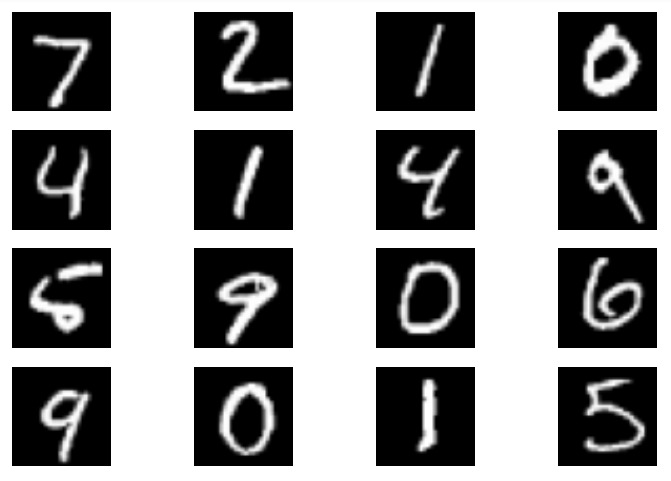

A sample of the generated MNIST data after the first epoch: \
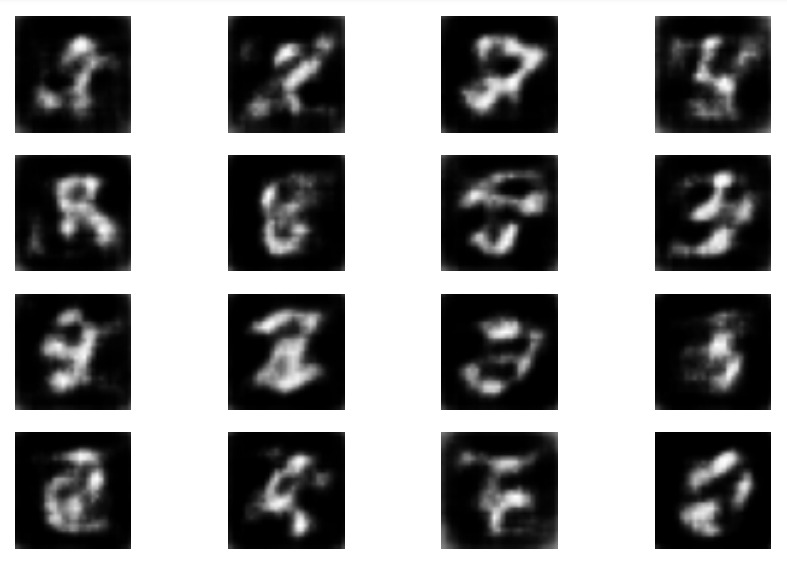

A sample of the generated MNIST data after the final epoch (#100): \
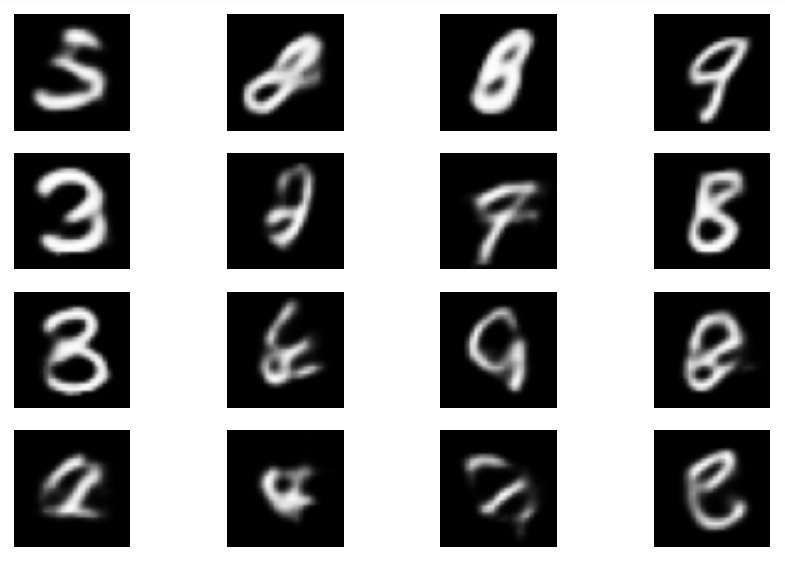

ANSWER:\
(a) As it can be seen, most generations are well done and can be recognized as number. Of course they are not perfect, some of them are like scribbles and most of them are blurry (which is a common disadvantage within VAEs). A pontential reason for this can be the use of a small network, maybe a bigger network could have improved the results. However, we can say that the model is able to generate synthetic numbers, and therefore, that it has had a successful training. 

When comparing the generations between epochs, we could observe a very slow improvement on the generated images. This makes sense taking into account that both the encoder and the decoder had to be trained. But when comparing the first generations with the last ones, we can observed an important difference. It can be easily seen that in the first epochs, all the generations are just scriblles, while in the last ones, almost every number is recognizable. This means that the model was properly trained.

(b) When evaluating the performance of a generative model, looking at the generated data is not sufficient. It can give a clue whether the model is working properly or not. If it is generating quality synthetic data, then the model is working properly. If not, the generated data does not give any information about what is wrong. Generative models usually consist of several parts, for example, VAEs consist of the encoder, prior and decoder and GANs consist of a generator and a discriminator. Evaluating a model by the generated data brings difficulties when backpropagating the error. Apart form that, it is difficult to assess where the problem is, e.g. if it is on the encoder or in the decoder in a VAE. Therefore, a loss function that summarizes the losses of all individual parts of the model, and that allows backpropagation is needed. This is the case of ELBO/NELBO, Negative log-likelihood or Adversarial loss. Other possible evaluation methods, that consist of looking at the generated data are Mean Squared Error and Cross-Entropy. These assessment methods compare the generated data with the target, and compute the loss in a differentiable way, that enables the backpropagation.

#### Question 9 (1.25 pt)

Please include the plot of the negative ELBO. Please comment on the following:
- (0.25 pt) Is the training of your VAE stable or unstable? Why?
- (1 pt) What is the influence of the optimizer on your model? Do the hyperparameter values of the optimizer important and how do they influence the training? Motivate well your answer (e.g., run the script with more than one learning rate and present two plots here).

The training process of the Negative ELBO - using the Adam optimizer and learning rate 0.001: \
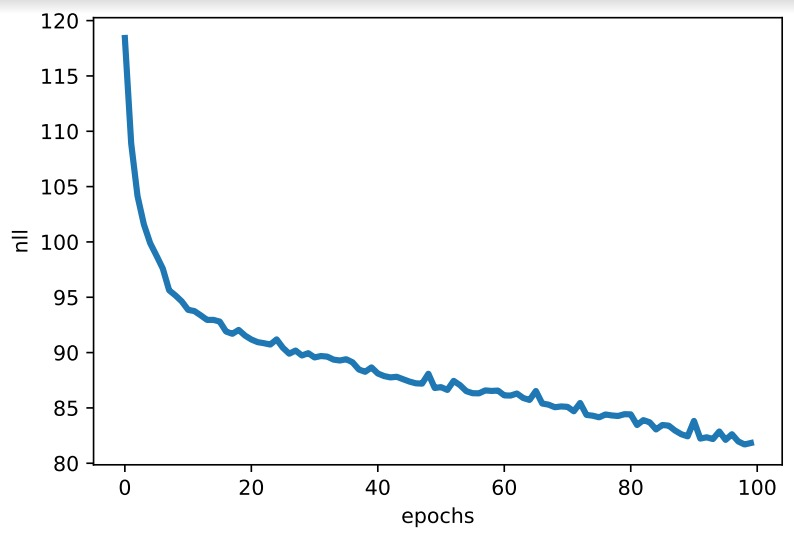

The training process of the Negative ELBO - using the Adam optimizer and learning rate 0.0001: \
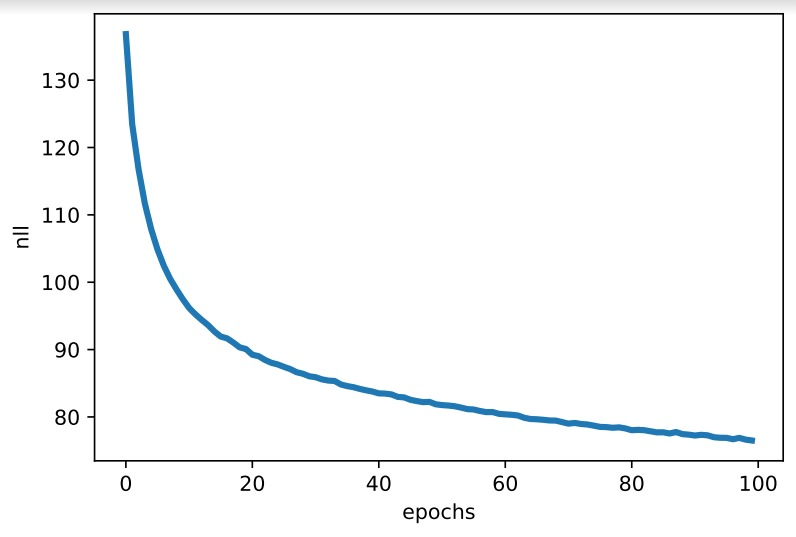

ANSWER: \

(a) As it can be seen form both learning curves, there is not a great disturbance in the progress, which means that the training is stable.  In general, VAEs have a stable training, so if the model is correctly implemented, with an appropiate batch size and is properly scaled, it should have a stable training. We can also observe that the learning progress with learning rate 0.0001 is more stable that with 0.001, which suggests that the 0.0001 is a more appropiate learning rate for this task.

(b) The optimizer has a big influence in the training process. As in any other Machine Learning model, the optimizer is the algorithm that specifies how parameters will be updated. Therefore, a good optimizer is paramount for successful model. Adam is a commonly used optimizer in Deep Learning, having proved its efficiency. However, the learning rate is yet to be studied. The learning rate influences how drastically the parameters are updated. This means that if we have a small leraning rate, parameters could learn to slow, needing many epochs, or even get stuck at a local minimum. However, if the learning rate is to big, the algorithm may fail to converge. 

Therefore, the performance with different learning rates have been studied. Learning rates $1*10^{-3}$ and $1*10^{-4}$ were studied. As it can be observed, both models have a similar training process and final performance. Nevertheless, with $1*10^{-4}$ the training progress is more stable, and the model is even able to reach a higher performance. The model with the learning rate $1*10^{-3}$ reached a final negative log-likelihood of 80.28, while the model with learning rate $1*10^{-4}$ reached a final loss of 75.63. A possible explanation for this finding is that in the beginning the network learns faster with learning rate $1*10^{-3}$ but then the parameters update might be too big to have an efficient training. While with 0.0001 it trains more smoothly and theregfore ends up with a better performance.